In [27]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
#from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
import math

## Model 1

In [28]:
start = dt.datetime(2009, 1, 1)
end = dt.datetime(2021, 1, 1)

data = pdr.get_data_yahoo('6758.T', start, end)
data = data.reset_index()
data = data.dropna()
data = data.drop_duplicates(subset = 'Date')
#data1 = data.copy()

[*********************100%***********************]  1 of 1 completed


In [29]:
train_data = data[data['Date']<"2018-01-01"]
test_data = data[data['Date']>="2018-01-01"]

In [30]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

In [31]:
window_size = 3

x_train, y_train =[], []
for x in range(window_size, len(scaled_data)):
    x_train.append(scaled_data[x-window_size:x, 0])
    y_train.append(scaled_data[x, 0])

In [32]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [33]:
%%capture

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
history = model.fit(x_train, y_train, epochs=5, batch_size=30,callbacks=[es])

2023-06-05 11:29:43.379585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 11:29:43.381604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 11:29:43.383096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-05 11:29:47.497227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 11:29:47.500157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 11:29:47.502362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [34]:
inputs=data['Close'][len(data['Close'])-len(test_data)-window_size:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [35]:
x_test=[]

for x in range(window_size, len(inputs)):
    x_test.append(inputs[x-window_size:x, 0])

x_test=np.array(x_test)
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices=model.predict(x_test)
predicted_prices=scaler.inverse_transform(predicted_prices)

2023-06-05 11:29:53.402426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-05 11:29:53.405368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-05 11:29:53.407588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 1s 3ms/step


In [36]:
predicted_prices1 = predicted_prices.copy()
predicted_prices = predicted_prices[5:]

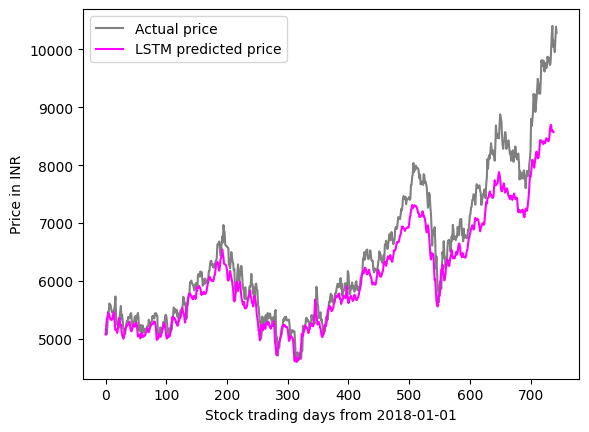

In [37]:
#Plot test predction
plt.plot(test_data.reset_index()['Close'], color = 'grey', label = 'Actual price')
plt.plot(predicted_prices, color = 'magenta', label = 'LSTM predicted price')

plt.xlabel('Stock trading days from 2018-01-01')
plt.ylabel('Price in INR')
plt.legend()
plt.show()

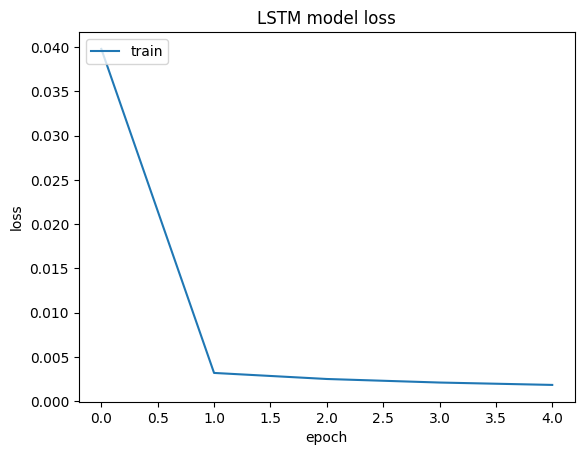

In [38]:
plt.plot(history.history['loss'])
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
math.sqrt(metrics.mean_squared_error(test_data['Close'].values[5:],predicted_prices))

509.1550478373547

In [40]:
metrics.mean_absolute_error(test_data['Close'].values[5:],predicted_prices)

379.9973240337449

## Model 2

In [41]:
data2 = test_data.copy()

In [42]:
data2['SMA'] = data2['Close'].rolling(window_size).mean()

In [43]:
data2 = data2.reset_index()

In [44]:
df = pd.DataFrame({'act1':test_data['Close'].values.ravel(), 'pred1':predicted_prices1.ravel()})

In [45]:
data2 = pd.merge(data2, df, left_on ='Close', right_on ='act1',how='left')

In [46]:
data2 = data2.drop_duplicates(subset = 'Date')

In [47]:
data2 = data2.reset_index()

<function matplotlib.pyplot.show(close=None, block=None)>

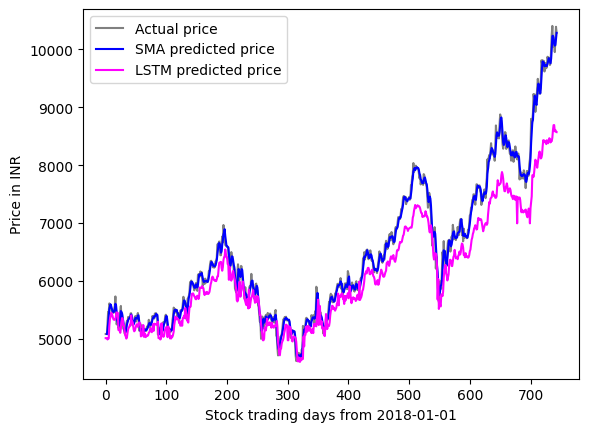

In [48]:
plt.plot(data2['act1'], label = 'Actual price', color = 'grey')
plt.plot(data2['SMA'], label = 'SMA predicted price', color = 'blue')
plt.plot(data2['pred1'], label = 'LSTM predicted price', color = 'magenta')





plt.xlabel('Stock trading days from 2018-01-01')
plt.ylabel('Price in INR')

plt.legend()
plt.show

In [49]:
math.sqrt(metrics.mean_squared_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna()))

88.62383278580317

In [50]:
metrics.mean_absolute_error(data2['act1'][window_size-1:].dropna(), data2['SMA'].dropna())

65.2349505840072

In [51]:
residuals = test_data['Close'].values[5:]-predicted_prices
residuals = residuals.tolist()

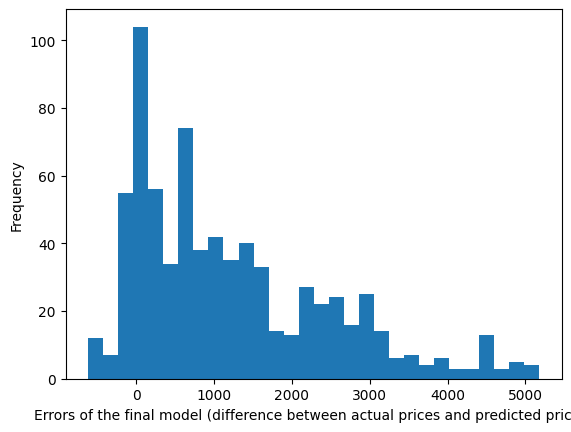

In [52]:
plt.hist(residuals[1], bins = 30)
plt.xlabel('Errors of the final model (difference between actual prices and predicted prices)')
plt.ylabel('Frequency')
plt.show()

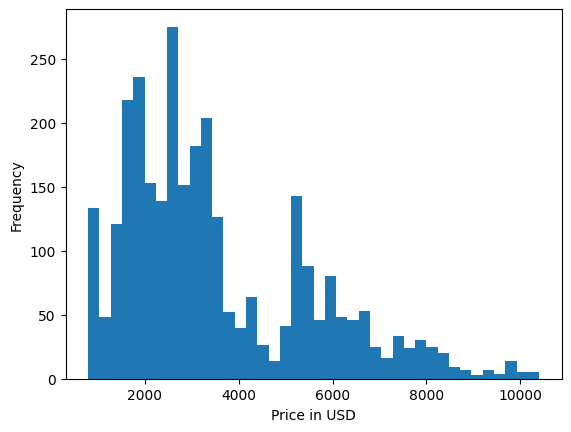

In [53]:
plt.hist(data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

# Data analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

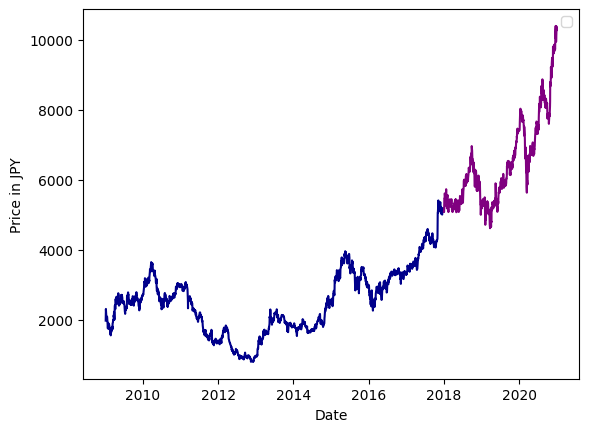

In [54]:
plt.plot(train_data['Date'],train_data['Close'], color ='darkblue')
plt.plot(test_data['Date'],test_data['Close'],color = 'purple')
plt.xlabel('Date')
plt.ylabel('Price in JPY')

plt.legend()
plt.show


In [ ]:
plt.hist(data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.hist(train_data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.hist(test_data['Close'],bins = 40)
plt.xlabel('Price in USD')
plt.ylabel('Frequency')
plt.show()

In [ ]:
adfuller(data['Close'])

In [ ]:
adfuller(train_data['Close'])

In [ ]:
adfuller(test_data['Close'])

In [ ]:
plt.plot(data['Close'].diff(periods=1).dropna())
plt.xlabel('Stock market days from 2009-01-01')
plt.ylabel('1 day of differenced price in USD')
plt.show()

In [ ]:
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 100)
plt.xlabel('1 day of differenced price in USD')
plt.ylabel('Frequency')
plt.show()

In [ ]:
adfuller(data['Close'].dropna().diff(periods=1).dropna()) 

In [ ]:
adfuller(scaled_data)
plt.hist(data['Close'].diff(periods=1).dropna(),bins = 50)

In [ ]:
### EXAMPLE

#perform augmented Dickey-Fuller test
#adfuller(data)

#(-0.9753836234744063,
# 0.7621363564361013,
# 0,
# 12,
# {'1%': -4.137829282407408,
#  '5%': -3.1549724074074077,
#  '10%': -2.7144769444444443},
# 31.2466098872313)
#Here’s how to interpret the most important values in the output:

#Test statistic: -0.97538
#P-value: 0.7621
#Since the p-value is not less than .05, we fail to reject the null hypothesis.

#This means the time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.


## För att få bort non-stationarity kan vi differentiera
#df["series"].diff(periods=1)


